In [1]:
from scipy.stats import mode
from numpy import linalg as LA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numba
import time
from scipy.sparse.linalg import eigs
from numpy.linalg import inv
import sys
from PFSA import PFSA
from matplotlib.ticker import MaxNLocator

<hr style="border:2px solid blue"> </hr>

## load the in-core and ex-core detector signal

In [2]:
# import the in-core and ex-core detector signal
Xn_IC = np.load("X_incore_normal.npz")
Xa_IC = np.load("X_incore_abnormal.npz")

print(Xn_IC.shape)
print(Xa_IC.shape)

(1000000001,)
(1000000001,)


<hr style="border:2px solid blue"> </hr>

## downsampling to fs = 100 Hz

In [3]:
Xn_IC =  Xn_IC[0:-1:10]
Xa_IC =  Xa_IC[0:-1:10]
print(Xn_IC.shape)
print(Xa_IC.shape)

(100000000,)
(100000000,)


#### Define sliding window slicing,
- __for newer numpy version, numpy.lib.stride_tricks.sliding_window_view is equivalent__

In [4]:
def sliding_window_slicing(a, no_items, item_type=0):
    
    # credit to : https://stackoverflow.com/questions/62253105/which-datatypes-do-i-have-to-use-to-write-this-function-in-cython
    
    """This method perfoms sliding window slicing of numpy arrays

    Parameters
    ----------
    a : numpy
        An array to be slided in subarrays
    no_items : int
        Number of sliced arrays or elements in sliced arrays
    item_type: int
        Indicates if no_items is number of sliced arrays (item_type=0) or
        number of elements in sliced array (item_type=1), by default 0

    Return
    ------
    numpy
        Sliced numpy array
    """
    if item_type == 0:
        no_slices = no_items
        no_elements = len(a) + 1 - no_slices
        if no_elements <=0:
            raise ValueError('Sliding slicing not possible, no_items is larger than ' + str(len(a)))
    else:
        no_elements = no_items                
        no_slices = len(a) - no_elements + 1
        if no_slices <=0:
            raise ValueError('Sliding slicing not possible, no_items is larger than ' + str(len(a)))

    subarray_shape = a.shape[1:]
    shape_cfg = (no_slices, no_elements) + subarray_shape
    strides_cfg = (a.strides[0],) + a.strides
    as_strided = np.lib.stride_tricks.as_strided #shorthand
    return as_strided(a, shape=shape_cfg, strides=strides_cfg)

<hr style="border:2px solid blue"> </hr>

## preparing the time series

In [5]:
fs = 100
Ns = 100000000
X_class1_train = Xn_IC[:int(Ns/2)] # use half of the time series as training set (normal)
X_class2_train = Xa_IC[:int(Ns/2)] # usee half of thee time series as training set (abnormal)
window = fs * 1000 # window size is 1000 seconds, correspondingly 1000 * 100 points
sample_size = len(X_class1_train) // window # the number of samples in the training set

X_class1_train = X_class1_train.reshape(sample_size, window) # reshape the training set (normal)
X_class1_train = X_class1_train.reshape(*X_class1_train.shape, 1) # reshape the training set step 2 (normal)
Y_class1_train = np.zeros(sample_size) # create the training set Ys (normal)

X_class2_train = X_class2_train.reshape(sample_size, window) # reshape the training set (abnormal)
X_class2_train = X_class2_train.reshape(*X_class2_train.shape, 1) # reshape the training set step 2 (abnormal)
Y_class2_train = np.ones(sample_size) # create the training set Ys (abnormal)

X_train = np.concatenate([X_class1_train, X_class2_train]) # prepare the training set X (combine the normal and abnormal together)
Y_train = np.concatenate([Y_class1_train, Y_class2_train]) # prepare the training set Y

X_test_class1 = Xn_IC[int(Ns/2):int(Ns/2)+int(Ns/100)] # only 10000 seconds are used for testing, no need to do all
X_test_class2 = Xa_IC[int(Ns/2):int(Ns/2)+int(Ns/100)] # see above

X_test = np.concatenate([X_test_class1, X_test_class2])
X_test = sliding_window_slicing(X_test, fs*1000, 1) # window size is 1000 seconds, correspondingly 1000 * 100 points
X_test = X_test[1::fs] # no need to test time point of sampling, instead test every seconds
X_test = X_test.reshape(*X_test.shape, 1) # reshape the X

In [6]:
depth = 1
n_partitioning = 50
normalizaiton_method = 'mixed classes'
classfiers = ['projection 2']
model = PFSA(n_partitioning = n_partitioning, depth = depth, train_regime= normalizaiton_method)
model.fit(X_train, Y_train)
y_test_predicted = model.predict(X_test, classifier=classfiers)

normalization for all classes together
get the same bounds for all classes


C:\Users\xxc90\Dropbox\researchProject\neutronNoise_paper\PFSA.py:452: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "determine_partitioning_bounds" failed type inference due to: No implementation of function Function(<built-in function mul>) found for signature:
 
 >>> mul(int64, list(int64)<iv=None>)
 
There are 12 candidate implementations:
   - Of which 10 did not match due to:
   Overload of function 'mul': File: <numerous>: Line N/A.
     With argument(s): '(int64, list(int64)<iv=None>)':
    No match.
   - Of which 2 did not match due to:
   Operator Overload in function 'mul': File: unknown: Line unknown.
     With argument(s): '(int64, list(int64)<iv=None>)':
    No match for registered cases:
     * (int64, int64) -> int64
     * (int64, uint64) -> int64
     * (uint64, int64) -> int64
     * (uint64, uint64) -> uint64
     * (float32, float32) -> float32
     * (float64, float64) -> float64
     * (complex64, complex64) -

get symbols for all classes


C:\Users\xxc90\Dropbox\researchProject\neutronNoise_paper\PFSA.py:627: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_ravel_index" failed type inference due to: non-precise type pyobject
During: typing of argument at C:\Users\xxc90\Dropbox\researchProject\neutronNoise_paper\PFSA.py (629)

File "PFSA.py", line 629:
    def _ravel_index(self, x, dims):
        (x_l, x_m, x_n) = x.shape
        ^

  @numba.jit(boundscheck=True)
C:\Users\xxc90\Dropbox\researchProject\neutronNoise_paper\PFSA.py:627: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "_ravel_index" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "PFSA.py", line 636:
    def _ravel_index(self, x, dims):
        <source elided>
        # output is the index of the hypercube, in the above example case, return 1
        for l in range(0, x_l):
        ^

  @numba

get states for all classes


C:\Users\xxc90\Dropbox\researchProject\neutronNoise_paper\PFSA.py:548: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "generate_states" failed type inference due to: non-precise type pyobject
During: typing of argument at C:\Users\xxc90\Dropbox\researchProject\neutronNoise_paper\PFSA.py (553)

File "PFSA.py", line 553:
    def generate_states(self, x, depth, alphabet_size):
        <source elided>
        #   - columns are steps
        x = x.copy()
        ^

  @numba.jit(boundscheck=True)
C:\Users\xxc90\Dropbox\researchProject\neutronNoise_paper\PFSA.py:548: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "generate_states" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "PFSA.py", line 558:
    def generate_states(self, x, depth, alphabet_size):
        <source elided>
        else:
            (x_m, x_n) = x.shape
 

get morph matrix 0.000000


C:\Users\xxc90\Dropbox\researchProject\neutronNoise_paper\PFSA.py:573: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "cal_morph_matrix" failed type inference due to: non-precise type pyobject
During: typing of argument at C:\Users\xxc90\Dropbox\researchProject\neutronNoise_paper\PFSA.py (581)

File "PFSA.py", line 581:
    def cal_morph_matrix(self, x, states_size, regime='MAP'):
        <source elided>
        # print(series_lens)
        x = x.copy()
        ^

  @numba.jit(boundscheck=True)
C:\Users\xxc90\Dropbox\researchProject\neutronNoise_paper\PFSA.py:573: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "cal_morph_matrix" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "PFSA.py", line 590:
    def cal_morph_matrix(self, x, states_size, regime='MAP'):
        <source elided>

        for m in range(x_m):
       

get morph matrix 1.000000
class 0.000000, calculate the left eigenvector corresponding to left eigenvalue 1, this is the state probability vector.
class 0.000000, calculate the right eigenvectors corresponding to right eigenvalue (excludes eigen value 1).
class 1.000000, calculate the left eigenvector corresponding to left eigenvalue 1, this is the state probability vector.
class 1.000000, calculate the right eigenvectors corresponding to right eigenvalue (excludes eigen value 1).
class 0.000000, calculate state weight Chi
class 0.000000, calculate projection matrix 1
class 0.000000, calculate projection matrix 2
class 1.000000, calculate state weight Chi
class 1.000000, calculate projection matrix 1
class 1.000000, calculate projection matrix 2
class 0
normalization
get states for all classes
get morph matrix


C:\Users\xxc90\Miniconda3\envs\python38\lib\site-packages\scipy\sparse\linalg\eigen\arpack\arpack.py:936: LinAlgWarning: Diagonal number 50 is exactly zero. Singular matrix.
  self.M_lu = lu_factor(M)


class 1
normalization
get states for all classes
get morph matrix
get labels


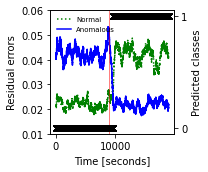

In [8]:
fig, ax0 = plt.subplots(1, 1, figsize=(3., 2.5))

#axs[0].text(9000, 0.2, t1, ha="left", rotation=90, wrap=False, fontsize=8)

ax0.set_xlabel("Time [seconds]")

#axs[0].vlines([9000], 0, 1, transform=axs[0].get_xaxis_transform(), linewidth=0.3, color="r")
ax0.vlines([9000], 0, 1, transform=ax0.get_xaxis_transform(), linewidth=0.5, color="r")
ax0.plot(model.distances_cl['projection 2'][:,0], ':', color= 'g', zorder=-2, label = 'Normal')
ax0.plot(model.distances_cl['projection 2'][:,1], color = 'b', zorder=-1, label = 'Anomalous')
ax0.set_ylabel("Residual errors")
ax0.set_ylim([0.01,0.06])
ax0.legend(frameon=False, loc=2, prop={'size': 7})
#t1 = ("Anomaly occurs")
#axs[0].text(9000, 0.02, t1, ha="left", rotation=90, wrap=True, fontsize=8, zorder = 100 )
#ax0_1.text(9000, 0.03, t1, ha="left", rotation=90, wrap=True, fontsize=8 , zorder = 100 )
ax0_1 = ax0.twinx()
ax0_1.plot(y_test_predicted,  'x', color="k", zorder = 0)
ax0_1.set_ylabel("Predicted classes")
ax0_1.yaxis.set_major_locator(MaxNLocator(integer=True))


fig.tight_layout()
plt.savefig("online_prediction_a.png", bbox_inches = "tight",
    pad_inches = 0, dpi=300)

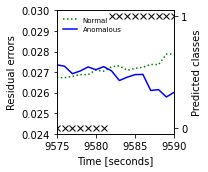

In [25]:
fig, ax0 = plt.subplots(1, 1, figsize=(3., 2.5))

#axs[0].text(9000, 0.2, t1, ha="left", rotation=90, wrap=False, fontsize=8)

ax0.set_xlabel("Time [seconds]")

#axs[0].vlines([9000], 0, 1, transform=axs[0].get_xaxis_transform(), linewidth=0.3, color="r")
ax0.vlines([9000], 0, 1, transform=ax0.get_xaxis_transform(), linewidth=0.5, color="r")
ax0.plot(model.distances_cl['projection 2'][:,0], ':', color= 'g', zorder=-2, label = 'Normal')
ax0.plot(model.distances_cl['projection 2'][:,1], color = 'b', zorder=-1, label = 'Anomalous')
ax0.set_ylabel("Residual errors")
ax0.set_ylim([0.024,0.03])
ax0.legend(frameon=False, loc=2, prop={'size': 7})
#t1 = ("Anomaly occurs")
#axs[0].text(9000, 0.02, t1, ha="left", rotation=90, wrap=True, fontsize=8, zorder = 100 )
#ax0_1.text(9000, 0.03, t1, ha="left", rotation=90, wrap=True, fontsize=8 , zorder = 100 )
ax0_1 = ax0.twinx()
ax0_1.plot(y_test_predicted,  'x', color="k", zorder = 0)
ax0_1.set_ylabel("Predicted classes")
ax0_1.yaxis.set_major_locator(MaxNLocator(integer=True))
ax0.set_xlim([9575,9590])

fig.tight_layout()
plt.savefig("online_prediction_b.png", bbox_inches = "tight",
    pad_inches = 0, dpi=300)

In [27]:
# save the results
np.save("online_distances_cl.py", model.distances_cl['projection 2'])
np.save("online_y_test_predicted.npy", y_test_predicted)